In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pims
import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 19

import os
import subprocess

In [53]:
def read_dat_file(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
      
    # Format the output string
    output_string = (
        f"particle_positions_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string,params


In [4]:
def read_dat_file_OP(filename):
    params = {}
    
    # Read the .dat file
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.split()
            params[key] = value
    
    # Format the output string
    output_string = (
        f"squared_disp_Dt_{params['Dt']}_Nparticles_{params['Nparticles']}_R_{params['R']}_T_{params['T']}_Vo_{params['Vo']}_aligstr_{params['aligstr']}_box_{params['box']}_cutoff_{params['cutoff']}_epsilon_{params['epsilon']}_eta_{params['eta']}_sigma_{params['sigma']}"
    )
    
    return output_string

In [5]:
## Read the positions of the particles for the movies
def read_positions(filename,N): 
    data= np.loadtxt(filename)
    X = data[:,0]
    Y = data[:,1]
    Theta = data[:,2]
    Steps = len(X) //N 
    X = np.reshape(X,(Steps,N))
    Y = np.reshape(Y,(Steps,N))
    Theta = np.reshape(Theta,(Steps,N))
    return X,Y,Theta


In [26]:
## organize into directories

def organize(params_file):

    file_name,params = read_dat_file(params_file)
    OP_str = read_dat_file_OP(params_file)
    os.makedirs(file_name,exist_ok=True)

    N=int(params['Nparticles'])
    T = int(params['T'])

    command = f"mv *{file_name[19:]}.dat {file_name}"
    subprocess.run(command,shell=True)

    return file_name,params,N,OP_str,T

file_name,params,N,OP_str,T = organize("params.dat")

mv: cannot stat '*Dt_0.1_Nparticles_1000_R_1_T_10000_Vo_0.5_aligstr_1_box_32_cutoff_0.5_epsilon_0.1_eta_0.9_sigma_0.5.dat': No such file or directory


In [62]:

## Create the movie

def movie(file_name,params,N,t0,tf):

    X,Y,Theta = read_positions(f'{file_name}/'+file_name+'.dat',N)
    fig, ax1 = plt.subplots(figsize=(5,5))  
    BOX_SIZE = float(params['box'])
    max_x = X.max()
    max_y = Y.max()
    scale = BOX_SIZE*0.024
    T = len(X)
    n_frames = 300

    # x,y = [], []
    fr= 0
    for time in range(t0,tf):
        ax1.clear()
        Xnow = X[time]
        Ynow = Y[time]
        Thetanow=Theta[time]
        # print(Thetanow)
        # Xnext = X[time+1]
        # Ynext = Y[time+1]
        # Xp_now = Xp[time]
        # Yp_now = Yp[time]
        for posx, posy,angle in zip(Xnow, Ynow,Thetanow):
            # lx= abs(-dx + posx)
            # ly = abs(-dy + posy)
            dx = np.cos(angle)*scale
            dy = np.sin(angle)*scale
            
            ax1.arrow(posx, posy, dx, dy, head_width=0.01*BOX_SIZE, head_length=0.01*BOX_SIZE,color='black')
            # ax1.add_patch(plt.Circle((posx, posy), radius=sigma, fill=True,color='red'))
            
            # if lx >= BOX_SIZE/2 or ly >= BOX_SIZE/2:
            #     ax1.plot(posx,posy,lw=0,marker='o',ms=0.01)
            # else:
            #     ax1.plot(np.array([posx,dx]),np.array([posy,dy]))
            
            
            ax1.set_title(f'time {time}',fontsize=12,loc='left')
            
        ax1.set_xlim(0,BOX_SIZE)
        ax1.set_ylim(0,BOX_SIZE)
        # ax1.set_xticks([0,BOX_SIZE//2, BOX_SIZE])
        # ax1.set_yticks([0,BOX_SIZE//2, BOX_SIZE])
        ax1.set_xticks([])
        ax1.set_yticks([])
        # ax1.set_xlabel(r'$x$')
        
        # ax1.set_ylabel(r'$y$')
        # ax1.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.savefig(f"{file_name}/positions_{fr:03d}.png",dpi=200)
        fr += 1
    plt.close()


    command = f"ffmpeg -r 15 -i '{file_name}/positions_%03d.png' -pix_fmt yuv420p {file_name}/movie.mp4"
    subprocess.run(command, shell=True)
    return None

# movie(file_name,params,N)

TypeError: movie() missing 2 required positional arguments: 't0' and 'tf'

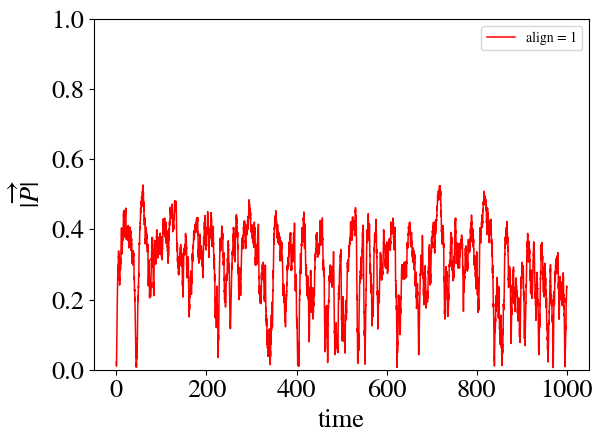

In [27]:

def plot_OP(file_name,OP_str,label):

    datamsd=np.loadtxt(f'{file_name}/'+OP_str+'.dat')
    time = datamsd[:,0]
    sq_p = datamsd[:,1]
    fig,ax = plt.subplots()

    ax.plot(time,sq_p, lw=1.1, color='red',label = label)
    ax.set_xlabel('time')
    ax.set_ylabel(r'$|\overrightarrow{P}|$')
    ax.set_ylim(0,1)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{file_name}/OP_vs_time.png',dpi=200,bbox_inches="tight")
    plt.savefig(f'{file_name}/OP_vs_time.pdf',dpi=200,bbox_inches="tight")
    plt.show()
    
    return None

plot_OP(file_name,OP_str,label=f'align = {params["aligstr"]}')

# Params sweepping 

In [ ]:
aligns = np.arange(3,4.5,0.5)

for align in aligns:    
    params_file = f"params_align_{align}.dat"
    file_name,params,N,OP_str,T = organize(params_file)
    movie(file_name,params,N)
    plot_OP(file_name,OP_str,label = f'alignstr = {align}')
    print(f'finished align {align}')


In [ ]:
# file_name,params,N,OP_str,T = organize("params_align_2.0.dat")
# movie(file_name,params,N)
file_name,params = read_dat_file("params_align_2.5.dat")
movie(file_name,params,N,600,800)

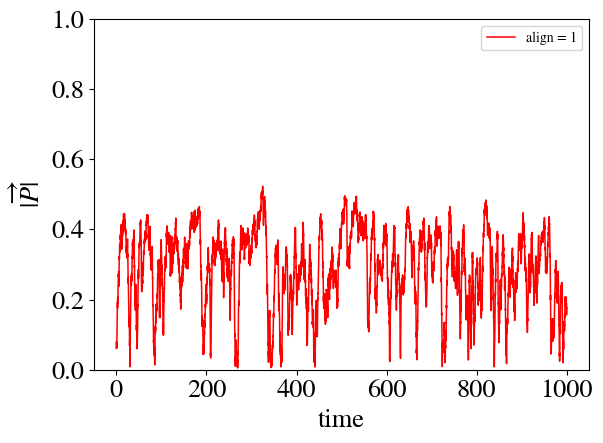

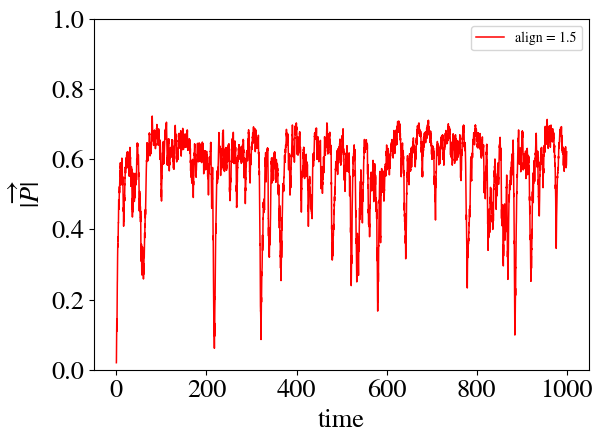

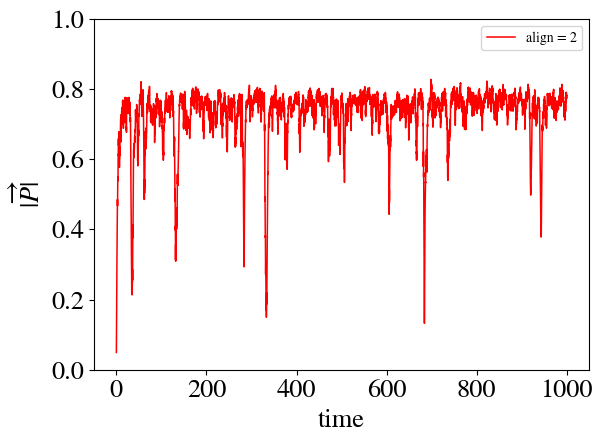

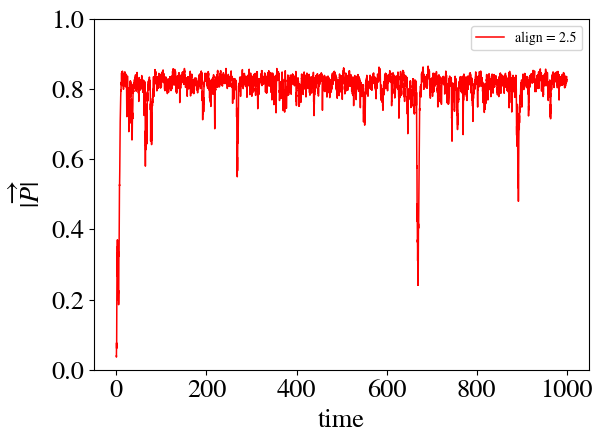

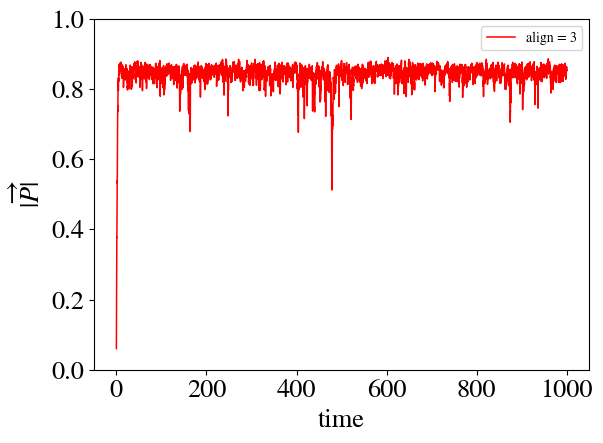

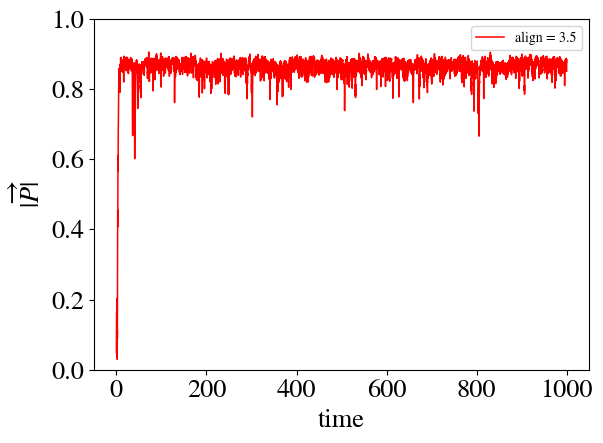

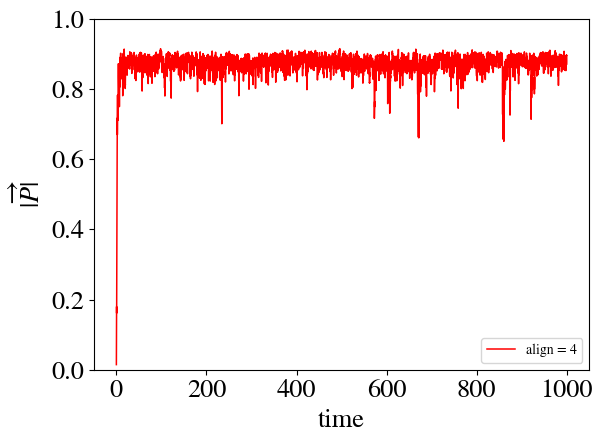

In [67]:


for align in np.arange(1,4.5,0.5):
    file_name,params = read_dat_file(f"params_align_{align}.dat")
    OP_str = read_dat_file_OP(f"params_align_{align}.dat")
    plot_OP(file_name,OP_str,label=f'align = {params["aligstr"]}')